This notebook is heavily (pretty much almost all of it) from here: https://github.com/meta-llama/llama-recipes/blob/main/recipes/use_cases/agents/langchain/langgraph-tool-calling-agent.ipynb

# Setup

- Set up your groq API key here: https://groq.com/
- Set up your Tavily Search API key here: https://tavily.com/

<a href="https://colab.research.google.com/github/meta-llama/llama-recipes/blob/main/recipes/use_cases/agents/langchain/langgraph-tool-calling-agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install -U langchain_groq langchain tavily-python replicate langgraph matplotlib

# LangGraph Tool Calling Agent with Llama3

LLM-powered agents combine planning, memory, and tool-use (see [here](https://lilianweng.github.io/posts/2023-06-23-agent/), [here](https://www.deeplearning.ai/the-batch/how-agents-can-improve-llm-performance/)). 

LangGraph is a library that can be used to build agents:
 
1) It allows us to define `nodes` for our assistant (which decides whether to call a tool) and our actions (tool calls).
2) It allows us to define specific `edges` that connect these nodes (e.g., based upon whether a tool call is decided).
3) It enables `cycles`, where we can call our assistant in a loop until a stopping condition.

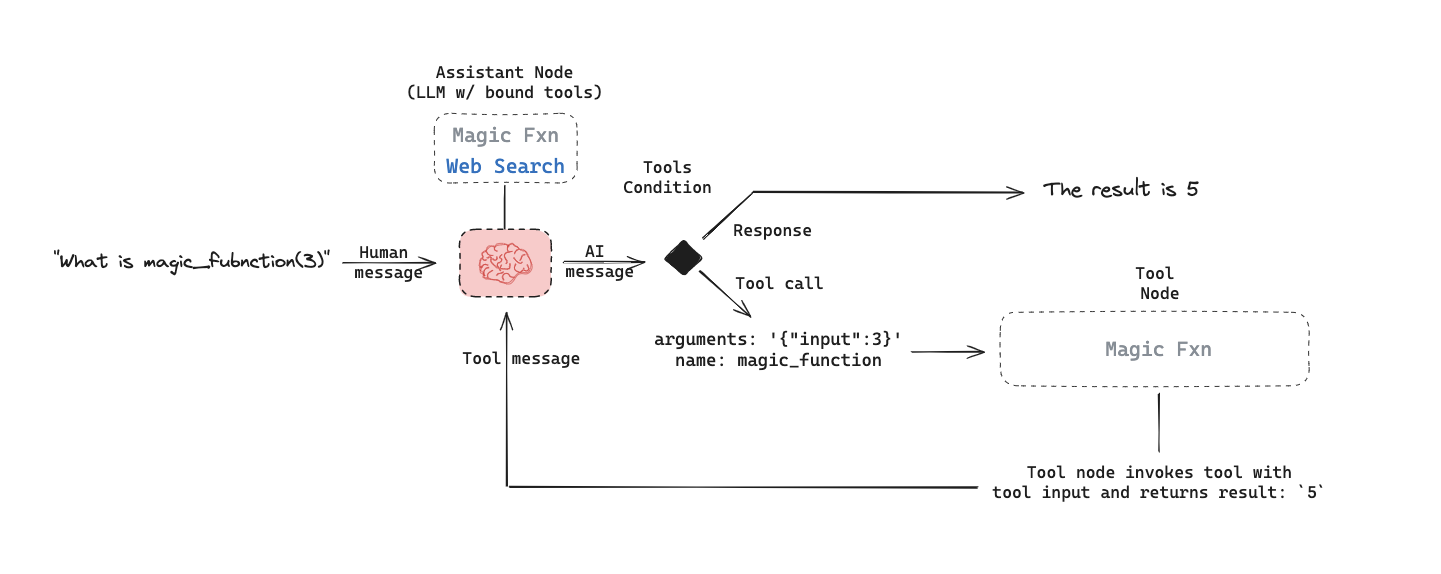

We'll augment a tool-calling version of Llama 3 with various multi-model capabilities using an agent. 

### Environment

We'll use [Tavily](https://tavily.com/#api) for web search.


We can review LangChain LLM integrations that support tool calling [here](https://python.langchain.com/docs/integrations/chat/).

Groq is included. [Here](https://github.com/groq/groq-api-cookbook/blob/main/llama3-stock-market-function-calling/llama3-stock-market-function-calling.ipynb) is a notebook by Groq on function calling with Llama 3 and LangChain.

In [1]:
import os
import getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("TAVILY_API_KEY")

In [2]:
import os
import getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("GROQ_API_KEY")

### Define tools

In [3]:
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from langchain_community.tools.tavily_search import TavilySearchResults

@tool
def magic_function(input: int) -> int:
    """Applies a magic function to an input."""
    return input + 2

@tool
def web_search(input: str) -> str:
    """Runs web search."""
    web_search_tool = TavilySearchResults()
    docs = web_search_tool.invoke({"query": input})
    return docs



def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )

def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print(f"Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }

# List of tools
tools = [
    magic_function,
    web_search,
]

### State

This list of messages is passed to each node of our agent.

This will serve as short-term memory that persists during the lifetime of our agent. 

See [this overview](https://github.com/langchain-ai/langgraph) of LangGraph for more detail.

In [4]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import AnyMessage, add_messages

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

### Assistant 

This is Llama 3, with tool-calling, using [Groq](https://python.langchain.com/v0.1/docs/integrations/chat/groq/).

We bind the available tools to Llama 3. 

And we further specify the available tools in our assistant prompt.

In [5]:
from datetime import datetime
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig

# Assistant
class Assistant:
    
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            # Get any user-provided configs 
            image_url = config['configurable'].get("image_url", None)
            # Append to state
            state = {**state, "image_url": image_url}
            # Invoke the tool-calling LLM
            result = self.runnable.invoke(state)
            # If it is a tool call -> response is valid
            # If it has meaninful text -> response is valid
            # Otherwise, we re-prompt it b/c response is not meaninful
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}

# Prompt 
primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant for with 2 tools: (1) web search, "
            "(2) a custom, magic_function, Use these provided tools in response to the user question. "
            "Current time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now())

# LLM chain
llm = ChatGroq(temperature=0, model="llama3-70b-8192")
assistant_runnable = primary_assistant_prompt | llm.bind_tools(tools)

### Graph

Here, we lay out the graph.

In [6]:
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import END, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.runnables import RunnableLambda

# Graph
builder = StateGraph(State)

# Define nodes: these do the work
builder.add_node("assistant", Assistant(assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(tools))

# Define edges: these determine how the control flow moves
builder.set_entry_point("assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition, 
    # "tools" calls one of our tools. END causes the graph to terminate (and respond to the user)
    {"tools": "tools", END: END},
)
builder.add_edge("tools", "assistant")

# The checkpointer lets the graph persist its state
memory = SqliteSaver.from_conn_string(":memory:")
graph = builder.compile(checkpointer=memory)

ValidationError: 1 validation error for CompiledStateGraph
checkpointer
  instance of BaseCheckpointSaver expected (type=type_error.arbitrary_type; expected_arbitrary_type=BaseCheckpointSaver)

We can visualize it.

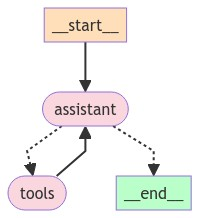

In [5]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

### Test

Now, we can test each tool!

See the traces to audit specifically what is happening.

In [6]:
questions = ["What is magic_function(3)",
             "What is the weather in SF?",
            ]

In [7]:
import uuid 
_printed = set()
image_url = None
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        "image_url": image_url,
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

events = graph.stream(
    {"messages": ("user", questions[0])}, config, stream_mode="values"
)
for event in events:
    _print_event(event, _printed)

================================ Human Message =================================

What is magic_function(3)
================================== Ai Message ==================================
Tool Calls:
  magic_function (call_hzpv)
 Call ID: call_hzpv
  Args:
    input: 3
================================= Tool Message =================================
Name: magic_function

5
================================== Ai Message ==================================

The result of the magic_function is 5.


In [8]:
_printed = set()
image_url = None
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        "image_url": image_url,
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

events = graph.stream(
    {"messages": ("user", questions[1])}, config, stream_mode="values"
)
for event in events:
    _print_event(event, _printed)

================================ Human Message =================================

What is the weather in SF?
================================== Ai Message ==================================
Tool Calls:
  web_search (call_356a)
 Call ID: call_356a
  Args:
    input: weather in SF
================================= Tool Message =================================
Name: web_search

[{"url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'San Francisco', 'region': 'California', 'country': 'United States of America', 'lat': 37.78, 'lon': -122.42, 'tz_id': 'America/Los_Angeles', 'localtime_epoch': 1718141089, 'localtime': '2024-06-11 14:24'}, 'current': {'last_updated_epoch': 1718140500, 'last_updated': '2024-06-11 14:15', 'temp_c': 28.3, 'temp_f': 82.9, 'is_day': 1, 'condition': {'text': 'Sunny', 'icon': '//cdn.weatherapi.com/weather/64x64/day/113.png', 'code': 1000}, 'wind_mph': 12.5, 'wind_kph': 20.2, 'wind_degree': 310, 'wind_dir': 'NW', 'pressure_mb': 1012.0, 'pressure_in